# Install libraries

In [ ]:
!pip install -q -U transformers pytorch-lightning

In [ ]:
# Downlaod dataset
!gdown 1e7iP_EWYV63rOHd-SF-5I1RF7IT2g84t

Downloading...
From: https://drive.google.com/uc?id=1e7iP_EWYV63rOHd-SF-5I1RF7IT2g84t
To: /notebooks/data.csv
100%|██████████████████████████████████████| 3.98M/3.98M [00:00<00:00, 94.5MB/s]


# Import libraries

In [ ]:
import torch
import pytorch_lightning as pl
import pandas as pd
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torch
from IPython.display import display
import numpy as np

In [ ]:
# Load dataset

data = pd.read_csv('/notebooks/data.csv', lineterminator='\n')

display(data.head())

texts = data['normalized_content']
texts = texts.tolist()

labels = data['score'].to_list()
labels = [float(i)/10.0 for i in labels]
len(data)

,normalized_content,score
0,Very friendly staff. Nice welcome.,8.0
1,staff were very helpful in booking the train o...,8.0
2,It was a superior experience. Accomodation was...,10.0
3,"Very helpful owner, any minor issues in the ro...",10.0
4,"The staff! They were amazing and so friendly, ...",10.0


14845

Visualize dataset

<ipython-input-5-9f91782ef5ed>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=data['score'])


<Axes: ylabel='Density'>

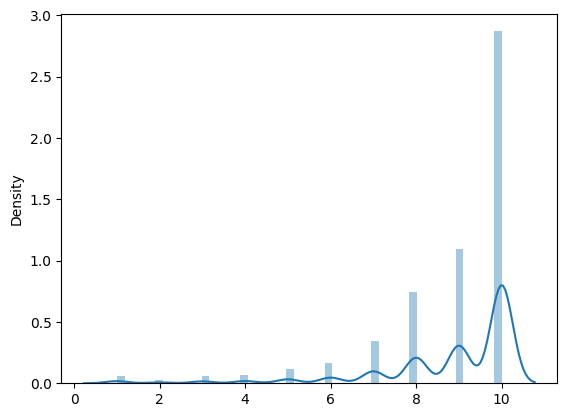

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(x=data['score'])

Word cloud

In [ ]:
low = data[data['score'] < 4]
medium = data[(data['score'] >= 4) & (data['score'] < 8)]
high = data[data['score'] >= 8]

In [ ]:
!pip install wordcloud

In [ ]:
# Stopwords
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

low_text = ''


stop_words = set(stopwords.words('english'))

for text in low['normalized_content']:
    text = word_tokenize(text)
    low_text += ' '.join([t.lower() for t in text if t.lower() not in stop_words])

medium_text = ''
for text in medium['normalized_content']:
    text = word_tokenize(text)
    medium_text += ' '.join([t.lower() for t in text if t.lower() not in stop_words])

high_text = ''
for text in high['normalized_content']:
    text = word_tokenize(text)
    high_text += ' '.join([t.lower() for t in text if t.lower() not in stop_words])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Text(0.5, 1.0, 'Low score word cloud')

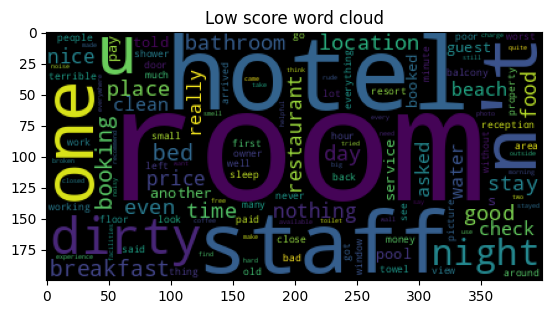

In [ ]:
wc = WordCloud().generate(low_text)
plt.imshow(wc)
plt.title('Low score word cloud')

Text(0.5, 1.0, 'Medium score word cloud')

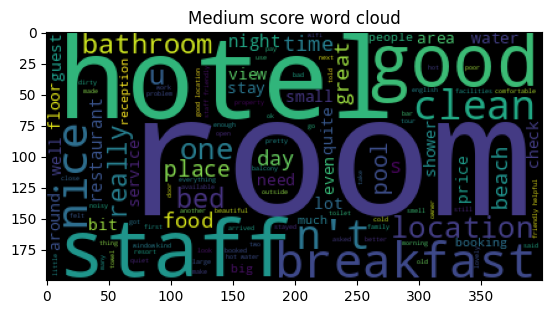

In [ ]:
wc = WordCloud().generate(medium_text)
plt.imshow(wc)
plt.title('Medium score word cloud')

Text(0.5, 1.0, 'High score word cloud')

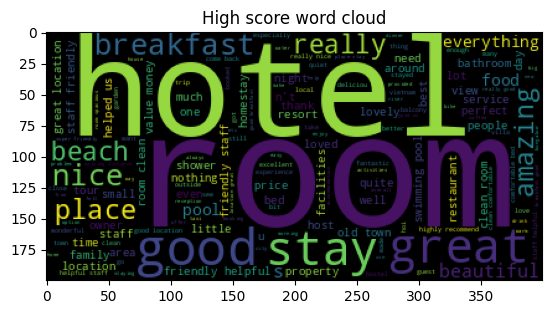

In [ ]:
wc = WordCloud().generate(high_text)
plt.imshow(wc)
plt.title('High score word cloud')

# Define dataset module

In [ ]:
MODEL_NAME = 'roberta-base'

class CustomDataset(Dataset):

    def __init__(self,
                 texts, labels,
                 tokenizer, max_length):

        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding = 'max_length',
            truncation = True,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()

        # Check error
        assert input_ids.shape[0] == attention_mask.shape[0] == self.max_length

        return {
            'inputs_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(label, dtype=torch.float)
        }

# Define Bert backbone module

In [ ]:
class BERTClassifier(pl.LightningModule):

    def __init__(self, learning_rate=2e-5, MODEL_NAME=MODEL_NAME):
        super(BERTClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(MODEL_NAME)
        self.linear = torch.nn.Sequential(
            torch.nn.Linear(self.bert.config.hidden_size, 50),
            torch.nn.Linear(50, 10),
            torch.nn.Linear(10, 1)
        )

        self.learning_rate = learning_rate

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # Shape output to [batch_size, seq_len, feature_dim]
        # linear1 = self.linear1(outputs.last_hidden_state[:, 0])
        # linear2 = self.linear2(linear1)
        # linear3 = self.linear3(linear2)
        linear = self.linear(outputs.last_hidden_state[:, 0])
        return linear

    def training_step(self, batch, batch_idx):
        input_ids = batch['inputs_ids']
        attention_mask = batch['attention_mask']
        labels = torch.reshape(batch['labels'], (-1, 1))

        predicted_value = self(input_ids, attention_mask)
        loss = F.mse_loss(predicted_value, labels)
        self.log(
            'train_loss', loss,
            on_step=True, on_epoch=True,
            prog_bar=True
        )

        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch['inputs_ids']
        attention_mask = batch['attention_mask']
        labels = torch.reshape(batch['labels'], (-1, 1))

        predicted_value = self(input_ids, attention_mask)
        val_loss = F.mse_loss(predicted_value, labels)
        self.log(
            'val_loss', val_loss,
            on_step=True, on_epoch=True,
            prog_bar=True
        )

        return val_loss

    def test_step(self, batch, batch_idx):
        input_ids = batch['inputs_ids']
        attention_mask = batch['attention_mask']
        labels = torch.reshape(batch['labels'], (-1, 1))

        predicted_value = self(input_ids, attention_mask)
        test_loss = F.mse_loss(predicted_value, labels)
        self.log(
            'test_loss', test_loss,
            on_step=True, on_epoch=True,
            prog_bar=True
        )
        return test_loss

    def predict_step(self, batch, batch_idx):
        input_ids = batch['inputs_ids']
        attention_mask = batch['attention_mask']
        outputs = self(input_ids, attention_mask)
        return outputs * 10

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr = self.learning_rate
        )
        return optimizer


class BERTDataModule(pl.LightningDataModule):

    def __init__(self, texts, labels, batch_size, max_length, num_workers):
        super().__init__()
        self.texts = texts
        self.labels = labels
        self.batch_size = batch_size
        self.max_length = max_length
        self.tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
        self.num_workers = num_workers

    def setup(self, stage=None):

        texts_train, texts_val, labels_train, labels_val = train_test_split(
            self.texts, self.labels,
            test_size=0.2, random_state=0
        )
        text_test, text_val, label_test, label_val = train_test_split(
            texts_val, labels_val,
            test_size=0.25, random_state=0
        )

        self.train_dataset = CustomDataset(
            texts=texts_train,
            labels=labels_train,
            tokenizer=self.tokenizer,
            max_length=self.max_length
        )
        self.val_dataset = CustomDataset(
            texts=text_val,
            labels=label_val,
            tokenizer=self.tokenizer,
            max_length=self.max_length
        )
        self.test_dataset = CustomDataset(
            texts=text_test,
            labels=label_test,
            tokenizer=self.tokenizer,
            max_length=self.max_length
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers
        )

In [ ]:
# Load model and batch dataset

batch_size = 48
max_length = 128
num_workers = 2

data_module = BERTDataModule(
    texts, labels,
    batch_size=batch_size,
    max_length=max_length,
    num_workers=num_workers
)
model = BERTClassifier()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model_checkpoint = ModelCheckpoint(
    dirpath='checkpoint/',
    monitor='val_loss',
    verbose=True,
    mode='min',
    save_top_k=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    mode='min',
    min_delta=1e-4,
    patience=5
)

call_backs = [model_checkpoint, early_stopping]

trainer = pl.Trainer(
    max_epochs=5,
    detect_anomaly=True,
    callbacks=call_backs
)

trainer.fit(model, data_module)

INFO:pytorch_lightning.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /content/checkpoint exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type         | Params
-----------------------------------------
0 | bert    | RobertaModel | 124 M 
1 | linear1 | Linear       | 38.5 K
2 | linear2 | Linear       | 510   
3 | linear3 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 248: 'val_loss' reached 0.01475 (best 0.01475), saving model to '/content/checkpoint/epoch=0-step=248-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 496: 'val_loss' reached 0.01169 (best 0.01169), saving model to '/content/checkpoint/epoch=1-step=496.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 744: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 992: 'val_loss' reached 0.01120 (best 0.01120), saving model to '/content/checkpoint/epoch=3-step=992.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 1240: 'val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
print(trainer.test(model, data_module))

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_loss_epoch      │   0.009427586570382118    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 0.009427586570382118}]


In [ ]:
test_loader = data_module.test_dataloader()
pred = trainer.predict(model, test_loader)

idx = np.random.randint(0, 48, 5)

for i in idx:
    print('*'*50)
    print('Text: ', test_loader.dataset.texts[i])
    print('Gold Label: ', test_loader.dataset.labels[i]*10)
    print('Predicted Label: ', pred[0][i].item())
    print('*'*50)
    print()


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

**************************************************
Text:  Incredible riverside stay - we loved the peace and quiet away from hectic Sapa town. The trek arranged by the hotel was amazing - our guide (Sa) was brilliant. The hotel is located at the foot of the hills so no need for driving. The scenery on the walk was beautiful with brilliant lunch, views, the opportunity to swim.
Gold Label:  10.0
Predicted Label:  9.38461971282959
**************************************************

**************************************************
Text:  good location bad smell at elavator and room
Gold Label:  8.0
Predicted Label:  5.699263572692871
**************************************************

**************************************************
Text:  Very nice place on nice location. I love the view over the river with the boats passing by. Wonderful pool and wonderful green setting all over. Friendly service. And so rare in this kind of resort: real orange juice at breakfast! Just the kind of s

BERT-BASE-CASED

In [ ]:
# Load model and batch dataset

batch_size = 48
max_length = 256
num_workers = 2
MODEL_NAME = 'bert-base-cased'

data_module = BERTDataModule(
    texts, labels,
    batch_size=batch_size,
    max_length=max_length,
    num_workers=num_workers
)
model_1 = BERTClassifier(learning_rate=2e-5,MODEL_NAME = MODEL_NAME)

model_checkpoint = ModelCheckpoint(
    dirpath='checkpoint/',
    monitor='val_loss',
    verbose=True,
    mode='min',
    save_top_k=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    mode='min',
    min_delta=1e-4,
    patience=5
)

call_backs = [model_checkpoint, early_stopping]

trainer_1 = pl.Trainer(
    max_epochs=5,
    detect_anomaly=True,
    callbacks=call_backs
)

trainer_1.fit(model_1, data_module)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory checkpoint/ exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type      | Params
--------------------------------------
0 | bert    | BertModel | 108 M 
1 | linear1 | Linear    | 38.5 K
2 | linear2 | Linear    | 510   
3 | linear3 | Linear    | 11    
--------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.397   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 248: 'val_loss' reached 0.01183 (best 0.01183), saving model to 'checkpoint/epoch=0-step=248-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 496: 'val_loss' reached 0.01120 (best 0.01120), saving model to 'checkpoint/epoch=1-step=496.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 744: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 992: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 1240: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
print(trainer_1.test(model_1, data_module))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_loss_epoch      │   0.011418496258556843    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 0.011418496258556843}]


In [ ]:
test_loader = data_module.test_dataloader()
pred = trainer_1.predict(model_1, test_loader)

idx = np.random.randint(0, 48, 5)

for i in idx:
    print('*'*50)
    print('Text: ', test_loader.dataset.texts[i])
    print('Gold Label: ', test_loader.dataset.labels[i]*10)
    print('Predicted Label: ', pred[0][i].item())
    print('*'*50)
    print()


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

**************************************************
Text:  very nice host, that let me sleep in my room already free of charger because I arrived so early in the morning. the bathroom has seen better days
Gold Label:  8.0
Predicted Label:  9.067788124084473
**************************************************

**************************************************
Text:  interconnecting room for family
Gold Label:  8.0
Predicted Label:  8.633240699768066
**************************************************

**************************************************
Text:  nice and high-standard room, super confortable. the team at the hotel is charming and helpful. Its close by the main road, with restaurants and supermarkets, and access to a nice beach on a walking distance. 10 mins by motorbike(which can rented at the hotel) to the night market, and other nightclubs.
Gold Label:  10.0
Predicted Label:  9.409283638000488
**************************************************

*****************************

In [ ]:


# Load model and batch dataset

batch_size = 48
max_length = 256
num_workers = 2
MODEL_NAME = 'bert-base-cased'

data_module = BERTDataModule(
    texts, labels,
    batch_size=batch_size,
    max_length=max_length,
    num_workers=num_workers
)
model_2 = BERTClassifier(learning_rate=2e-5,MODEL_NAME = MODEL_NAME)

for name, module in model_2.named_modules():
    if isinstance(module, torch.nn.Sequential):
        layer_seq =torch.nn.Sequential(
            torch.nn.Linear(768, 100),
            torch.nn.Linear(100, 50),
            torch.nn.Linear(50, 20),
            torch.nn.Linear(20, 10),
            torch.nn.Linear(10, 1)
        )
        setattr(model_2, name, layer_seq)

model_checkpoint = ModelCheckpoint(
    dirpath='checkpoint/',
    monitor='val_loss',
    verbose=True,
    mode='min',
    save_top_k=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    mode='min',
    min_delta=1e-4,
    patience=5
)

call_backs = [model_checkpoint, early_stopping]

trainer_2 = pl.Trainer(
    max_epochs=5,
    detect_anomaly=True,
    callbacks=call_backs
)

trainer_2.fit(model_2, data_module)

You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type       | Params
--------------------------------------
0 | bert   | BertModel  | 108 M 
1 | linear | Sequential | 83.2 K
--------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.574   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 248: 'val_loss' reached 0.01163 (best 0.01163), saving model to 'checkpoint/epoch=0-step=248-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 496: 'val_loss' reached 0.01103 (best 0.01103), saving model to 'checkpoint/epoch=1-step=496-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 744: 'val_loss' reached 0.01087 (best 0.01087), saving model to 'checkpoint/epoch=2-step=744.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 992: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 1240: 'val_loss' reached 0.01057 (best 0.01057), saving model to 'checkpoint/epoch=4-step=1240.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
print(trainer_2.test(model_2, data_module))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_loss_epoch      │   0.010713763535022736    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 0.010713763535022736}]


In [ ]:
test_loader = data_module.test_dataloader()
pred = trainer_2.predict(model_2, test_loader)

idx = np.random.randint(0, 48, 5)

for i in idx:
    print('*'*50)
    print('Text: ', test_loader.dataset.texts[i])
    print('Gold Label: ', test_loader.dataset.labels[i]*10)
    print('Predicted Label: ', pred[0][i].item())
    print('*'*50)
    print()


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

**************************************************
Text:  I was skeptical to stay here, but took a leap of faith. The property was having great location everything was very close by, the beach is just 2mins walk. I really loved the ambiance, staff and facilities. The manager here has helped to a very great extent, i would definitely recommend everyone to come here and stay. Being a solo, indian and vegetarian traveller the hotel has been a blessing. If youre planning for bai chay, ha long i would definitely suggest go with them. loved everything!
Gold Label:  10.0
Predicted Label:  10.164037704467773
**************************************************

**************************************************
Text:  beautiful clean it all good
Gold Label:  10.0
Predicted Label:  9.571025848388672
**************************************************

**************************************************
Text:  Very nice place on nice location. I love the view over the river with the boats passing by

| Model | Metric  |
| --- | --- |
| Roberta | 0.009 |
| BERT-CASED | 0.01142 |
| BERT-CASED with 4 linear layers | 0.0107 |

Model Roberta cho kết quả tốt hơn so với BERT-CASED, do sự cải tiến từ model BERT và một số trick technique.